In [2]:
import pandas as pd
from sklearn.preprocessing import PowerTransformer, StandardScaler
from torch import nn
import numpy as np
from itertools import islice
import torch
import numpy
from sklearn.model_selection import train_test_split
import statistics as stats
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import mean_squared_error
from functions import MyLSTM, black_process, white_process

In [3]:
torch.set_default_dtype(torch.float64)

# Importing the data

In [4]:
def to_list(str):
    '''
    :param str: string representing a list of centipawn losses
    :return: list of integer centipawn losses
    '''
    string = str.replace('[','').replace(']','')
    ls = string.split(',')
    if '' in ls:
        print(f"WHAT THE FUCK : {str}")
    list = [float(i) for i in ls]
    return list

In [5]:
df = pd.read_csv('lichess_db_standard_rated_2023-08_1_1000000.csv', dtype  ={'Eval':'string'}, nrows = 10000)

In [6]:
# filtering out None or empty evaluations
df = df[ df['Eval'].apply(lambda x: isinstance(x, str))]
df = df[~df['Eval'].str.contains('None')]
df = df[df['Eval']!='']
df = df[df['Eval'] != '']
df = df[df['Eval'] != '[]']

In [7]:
df.value_counts('TimeControl')

TimeControl
600+0     1847
180+0     1816
60+0      1376
300+0     1142
180+2     1011
          ... 
720+10       1
780+3        1
840+10       1
960+14       1
960+19       1
Name: count, Length: 115, dtype: int64

In [8]:
# picking a time control - I'm looking at 3 minute games
df = df[df["Clock"] != '[]']
df = df[~df["Clock"].str.contains(',,')]

In [9]:
# defining a function to return initial time and increment
def get_init_time(string):
    t = string.split('+')
    return int(t[0])

def get_inc(string):
    t = string.split('+')
    return int(t[1])

In [10]:
# Filtering out * values
df = df[df['WhiteELO'] != '*']
df = df[df['BlackELO'] != '*']
df[['WhiteELO', 'BlackELO']] = df[['WhiteELO', 'BlackELO']] .astype(int)

# converting the evaluations and clock times to lists
df['Eval'] = df['Eval'].apply( to_list)
df['Clock'] = df['Clock'].apply(to_list)

df['Increment'] = df["TimeControl"].apply(get_inc)
df['Init_time'] = df["TimeControl"].apply(get_init_time)

# processing the evaluations and clock times into feature sequences
df['WhiteEval'] =df.apply(lambda x : white_process(x.Eval, x.Clock, x.Init_time, x.Init_time, x.Increment, x.BlackELO), axis =1 )
df['BlackEval'] = df.apply(lambda x : black_process(x.Eval, x.Clock,x.Init_time,x.Init_time,x.Increment,x.WhiteELO), axis =1 )

In [11]:
df['Clock'].head()

0    [300.0, 300.0, 299.0, 299.0, 298.0, 297.0, 297...
1    [300.0, 300.0, 295.0, 301.0, 293.0, 303.0, 292...
2    [300.0, 300.0, 299.0, 289.0, 276.0, 286.0, 273...
3    [180.0, 180.0, 181.0, 182.0, 183.0, 183.0, 184...
4    [60.0, 60.0, 60.0, 59.0, 59.0, 59.0, 59.0, 58....
Name: Clock, dtype: object

In [12]:
df.Eval

0       [0.0, 27.0, 29.0, 30.0, 16.0, 94.0, -74.0, 64....
1       [0.0, 27.0, 29.0, 30.0, 16.0, 27.0, 15.0, 21.0...
2       [0.0, 98.0, 80.0, 159.0, 23.0, 47.0, 19.0, 942...
3       [0.0, 90.0, 34.0, 30.0, 50.0, 126.0, 98.0, 117...
4       [0.0, 27.0, 13.0, 51.0, 2.0, 35.0, 3.0, 66.0, ...
                              ...                        
9995    [0.0, 20.0, 23.0, 30.0, 12.0, 0.0, 5.0, 12.0, ...
9996    [36.0, 82.0, 66.0, 75.0, 71.0, 92.0, 95.0, 97....
9997    [36.0, 37.0, 34.0, 24.0, 27.0, 33.0, 34.0, 45....
9998    [36.0, 82.0, 66.0, 74.0, 4.0, 141.0, 130.0, 32...
9999    [36.0, 35.0, 29.0, 32.0, 21.0, 51.0, -571.0, -...
Name: Eval, Length: 9981, dtype: object

In [13]:
df['WhiteEval'].head()

0    [[99.9999, 0.0, 300.0, 0.0, 1898.0], [100.8279...
1    [[99.9999, 0.0, 300.0, 3.0, 1554.0], [100.8279...
2    [[99.9999, 0.0, 300.0, 3.0, 1282.0], [93.00264...
3    [[99.9999, 0.0, 180.0, 2.0, 1835.0], [79.51409...
4    [[99.9999, 0.0, 60.0, 0.0, 1490.0], [94.378213...
Name: WhiteEval, dtype: object

In [14]:
df['BlackEval'].head()

0    [[89.42685016134062, 0.0, 300.0, 0.0, 1820.0],...
1    [[89.42685016134062, 0.0, 300.0, 3.0, 1606.0],...
2    [[66.78275170056337, 0.0, 300.0, 3.0, 1176.0],...
3    [[68.99392747162456, 0.0, 180.0, 2.0, 1828.0],...
4    [[89.42685016134062, 0.0, 60.0, 0.0, 1500.0], ...
Name: BlackEval, dtype: object

In [15]:
#copying black's evaluations to the same column as white's, so we examine each game from both perspectives
# NOTE: I'm filtering out some elos between 1200 and  2200 to try to get a larger range of predictions 
df_flipped = df.copy()
df_flipped['WhiteEval'] = df_flipped['BlackEval']
t = df_flipped['WhiteELO'].astype(float)
df_flipped['WhiteELO'] = df_flipped['BlackELO'].astype(float)
df_flipped['BlackELO'] = t
df_flipped['White'] = df_flipped['Black']
#df_flipped = df_flipped[ (df_flipped['WhiteELO'] <1200) | (df_flipped['WhiteELO'] >2200)]
df = pd.concat([df, df_flipped])

In [16]:
# Another idea is to predict the elo difference?

In [17]:
df['BlackELO'][0]

0    1898.0
0    1820.0
Name: BlackELO, dtype: float64

In [18]:
df['WhiteEval'][0]

0    [[99.9999, 0.0, 300.0, 0.0, 1898.0], [100.8279...
0    [[89.42685016134062, 0.0, 300.0, 0.0, 1820.0],...
Name: WhiteEval, dtype: object

In [19]:
print(len(df))

19962


In [20]:
print(f"Evaluted games: {len(df['Eval'])}")

Evaluted games: 19962


# Regularizing Data

In [21]:
white_x = numpy.array(df['WhiteEval'])
eval_length = numpy.array(df['WhiteEval'].apply(len))

In [22]:
white_x[1]

array([[9.99999000e+01, 0.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [1.00827985e+02, 5.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [9.43806011e+01, 2.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [9.51627422e+01, 1.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [9.16760325e+01, 0.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [7.96154296e+01, 1.80000000e+01, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [9.28502254e+01, 0.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [8.65052653e+01, 3.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [9.99999000e+01, 0.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [9.83637784e+01, 0.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [4.89420482e+01, 0.0000

In [23]:
eval_length

array([19, 26, 26, ..., 28, 23, 19])

In [24]:
# creating and fitting a power transformer for black and white
eval_pt = StandardScaler()

eval = numpy.concatenate(white_x) # concatenating so that the data has shape (samples,features)

In [25]:
eval[19:45]

array([[9.99999000e+01, 0.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [1.00827985e+02, 5.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [9.43806011e+01, 2.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [9.51627422e+01, 1.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [9.16760325e+01, 0.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [7.96154296e+01, 1.80000000e+01, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [9.28502254e+01, 0.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [8.65052653e+01, 3.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [9.99999000e+01, 0.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [9.83637784e+01, 0.00000000e+00, 3.00000000e+02, 3.00000000e+00,
        1.55400000e+03],
       [4.89420482e+01, 0.0000

In [26]:
eval_pt.fit(eval)
eval_transformed = eval_pt.transform(eval)

In [27]:
eval_transformed[:45]

array([[ 0.55675985, -0.42929633, -0.1325598 , -0.29332502,  0.61966279],
       [ 0.59678068, -0.34812873, -0.1325598 , -0.29332502,  0.61966279],
       [ 0.28518257, -0.34812873, -0.1325598 , -0.29332502,  0.61966279],
       [-1.87222774, -0.34812873, -0.1325598 , -0.29332502,  0.61966279],
       [ 0.49794573, -0.02345829, -0.1325598 , -0.29332502,  0.61966279],
       [ 0.16075643, -0.18579351, -0.1325598 , -0.29332502,  0.61966279],
       [-0.82994779, -0.18579351, -0.1325598 , -0.29332502,  0.61966279],
       [ 0.26705905, -0.34812873, -0.1325598 , -0.29332502,  0.61966279],
       [ 0.34353086, -0.26696112, -0.1325598 , -0.29332502,  0.61966279],
       [ 0.59123153, -0.18579351, -0.1325598 , -0.29332502,  0.61966279],
       [-2.95513774, -0.34812873, -0.1325598 , -0.29332502,  0.61966279],
       [ 0.03115336, -0.34812873, -0.1325598 , -0.29332502,  0.61966279],
       [-0.17991384, -0.02345829, -0.1325598 , -0.29332502,  0.61966279],
       [ 0.80789305, -0.34812873, -0.1

In [70]:
from joblib import dump
dump(eval_pt, 'eval_scaler.bin', compress=True)
dump(target_pt, 'target_scaler.bin', compress=True)

['target_scaler.bin']

<Axes: >

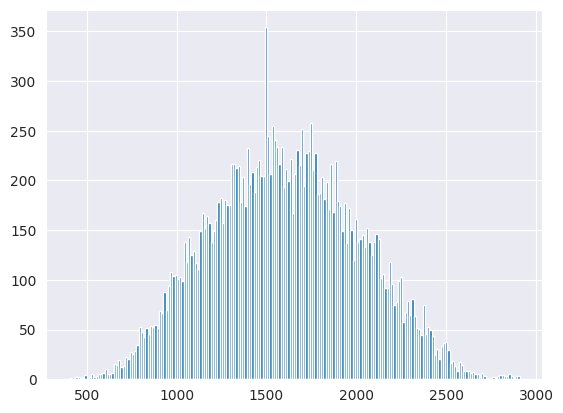

In [29]:
df['WhiteELO'].hist(bins = 200)

In [30]:
df['Target'] = df['WhiteELO']

In [31]:
target_arr = numpy.array(df['Target'])

In [32]:
#welopt = PowerTransformer(method = 'box-cox')
target_pt = StandardScaler()
target_arr = np.reshape(target_arr, (len(target_arr),1))
target_pt.fit(target_arr)
target_transformed = target_pt.transform(target_arr)

(array([  14.,   52.,  195.,  490.,  909., 1296., 1617., 1997., 2239.,
        2191., 2234., 1909., 1519., 1326.,  879.,  611.,  319.,  107.,
          26.,   32.]),
 array([-2.92349295, -2.61893723, -2.3143815 , -2.00982578, -1.70527006,
        -1.40071433, -1.09615861, -0.79160288, -0.48704716, -0.18249143,
         0.12206429,  0.42662002,  0.73117574,  1.03573146,  1.34028719,
         1.64484291,  1.94939864,  2.25395436,  2.55851009,  2.86306581,
         3.16762154]),
 <BarContainer object of 20 artists>)

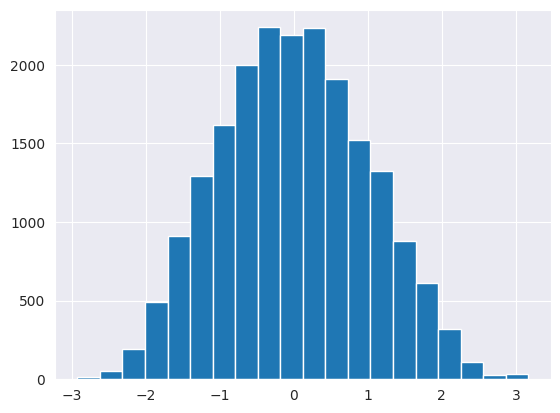

In [33]:
plt.hist(target_transformed, bins =20)

# The next cell is wrong!!

In [34]:
#eval_transformed_array = [numpy.array(list(islice(iter(eval_transformed), elem))) for elem in eval_length]

In [35]:
index = 0
ls = []
for length in eval_length:
    seq = eval_transformed[index: index+length -1]
    ls.append(seq)
    index += length
eval_transformed_array  = ls
    

In [36]:
eval_transformed_array[3]

array([[ 0.55675985, -0.42929633, -0.47837272,  0.16610318,  0.46683793],
       [-0.43330669, -0.51046394, -0.47837272,  0.16610318,  0.46683793],
       [ 0.97049922, -0.59163155, -0.47837272,  0.16610318,  0.46683793],
       [ 0.04829177, -0.51046394, -0.47837272,  0.16610318,  0.46683793],
       [-0.4842622 , -0.51046394, -0.47837272,  0.16610318,  0.46683793],
       [-0.30157971, -0.51046394, -0.47837272,  0.16610318,  0.46683793],
       [ 0.59654809, -0.51046394, -0.47837272,  0.16610318,  0.46683793],
       [ 0.47864824, -0.51046394, -0.47837272,  0.16610318,  0.46683793],
       [-0.09118353, -0.51046394, -0.47837272,  0.16610318,  0.46683793],
       [-0.45817466, -0.34812873, -0.47837272,  0.16610318,  0.46683793],
       [ 0.67380262, -0.34812873, -0.47837272,  0.16610318,  0.46683793],
       [-1.416106  ,  0.38237975, -0.47837272,  0.16610318,  0.46683793],
       [ 0.304363  , -0.42929633, -0.47837272,  0.16610318,  0.46683793],
       [-0.58385741, -0.51046394, -0.4

In [37]:
target_transformed[3]

array([0.54465357])

# Splitting data into a training and test set

In [38]:
# converting evaluations and length to tensors
evals = [torch.tensor(i, dtype = torch.float64) for i in eval_transformed_array]
lengths = [len(tensor) for tensor in evals]



In [39]:
def avg_cpl(white_processed):
    '''
    return the average centipawn loss from an evaluated game
    :param white_processed: list of lists of the form [evaluation, centipawn loss]
    :return: average centipawn loss (float)
    '''
    cpls = []
    for i in white_processed:
        cpls.append(i[1])
    if len(cpls) == 0:
        return float('NaN')
    else:
        return stats.mean(cpls)

In [40]:
df['White_avg_cpl'] = df['WhiteEval'].copy().apply( avg_cpl )

In [41]:
X = df[['White_avg_cpl','BlackELO']]
print(len(X))

19962


In [42]:
# Converting White and Black's ELOs to tensors
target = [torch.tensor(i, dtype = torch.float64) for i in target_transformed]

average_cpl = np.array(df['White_avg_cpl'])

# splitting into train and test
eval_train, eval_test, target_train, target_test, average_cpl_train, average_cpl_test, X_train,X_test = train_test_split(evals,target, average_cpl, X, test_size=0.2,random_state=0, shuffle = True)

In [43]:
# zipping together the features and targets
train_data_zip = list(zip(eval_train, target_train))
test_data_zip = list(zip(eval_test, target_test))

In [44]:
train_data_zip[0]

(tensor([[ 0.6370, -0.4293, -0.8242, -0.2933, -0.3604],
         [ 0.5568, -0.2670, -0.8242, -0.2933, -0.3604],
         [ 0.3473, -0.4293, -0.8242, -0.2933, -0.3604],
         [-2.9187,  1.0317, -0.8242, -0.2933, -0.3604],
         [ 0.1188, -0.3481, -0.8242, -0.2933, -0.3604],
         [-0.8522, -0.4293, -0.8242, -0.2933, -0.3604],
         [ 0.5764, -0.3481, -0.8242, -0.2933, -0.3604],
         [ 0.1545, -0.4293, -0.8242, -0.2933, -0.3604],
         [ 0.5170, -0.2670, -0.8242, -0.2933, -0.3604],
         [ 0.2660, -0.4293, -0.8242, -0.2933, -0.3604],
         [-0.6823, -0.3481, -0.8242, -0.2933, -0.3604],
         [ 0.5960, -0.2670, -0.8242, -0.2933, -0.3604],
         [-2.5221, -0.3481, -0.8242, -0.2933, -0.3604],
         [-3.3777, -0.4293, -0.8242, -0.2933, -0.3604],
         [-2.4624, -0.3481, -0.8242, -0.2933, -0.3604],
         [-3.6384, -0.4293, -0.8242, -0.2933, -0.3604],
         [-3.9593, -0.2670, -0.8242, -0.2933, -0.3604],
         [-3.6700, -0.4293, -0.8242, -0.2933, -0

In [45]:
# black_elo = torch.stack(black_elo)
# white_elo = torch.stack(white_elo)

## Baseline model

In [46]:
average_cpl_train = np.reshape(average_cpl_train, (len(average_cpl_train),1))
average_cpl_test = np.reshape(average_cpl_test, (len(average_cpl_test),1))

In [47]:
train_elo = np.array([x.item() for x in target_train])
train_elo = np.reshape(train_elo, (len(train_elo),1 ))
train_elo_transformed = target_pt.inverse_transform(train_elo)

test_elo = np.array([x.item() for x in target_test])
test_elo = np.reshape(test_elo, (len(test_elo),1 ))
test_elo_transformed = target_pt.inverse_transform(test_elo)

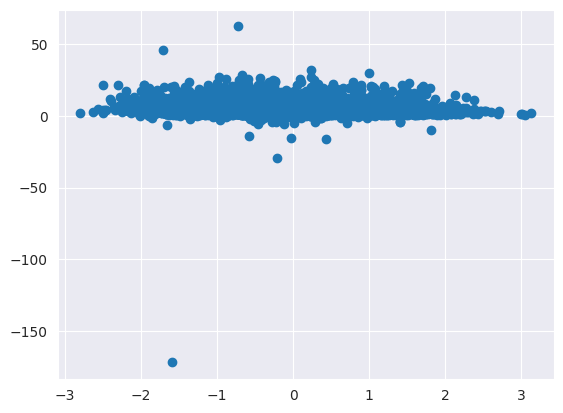

In [48]:
plt.scatter(test_elo,average_cpl_test)

In [49]:
# make a simple linear regression model.
regression = LinearRegression()
regression.fit(X_train,train_elo_transformed)
regression.score(X_test,test_elo)
y_pred = regression.predict(X_test)

In [50]:
mse_lin = mean_squared_error(test_elo_transformed, y_pred)

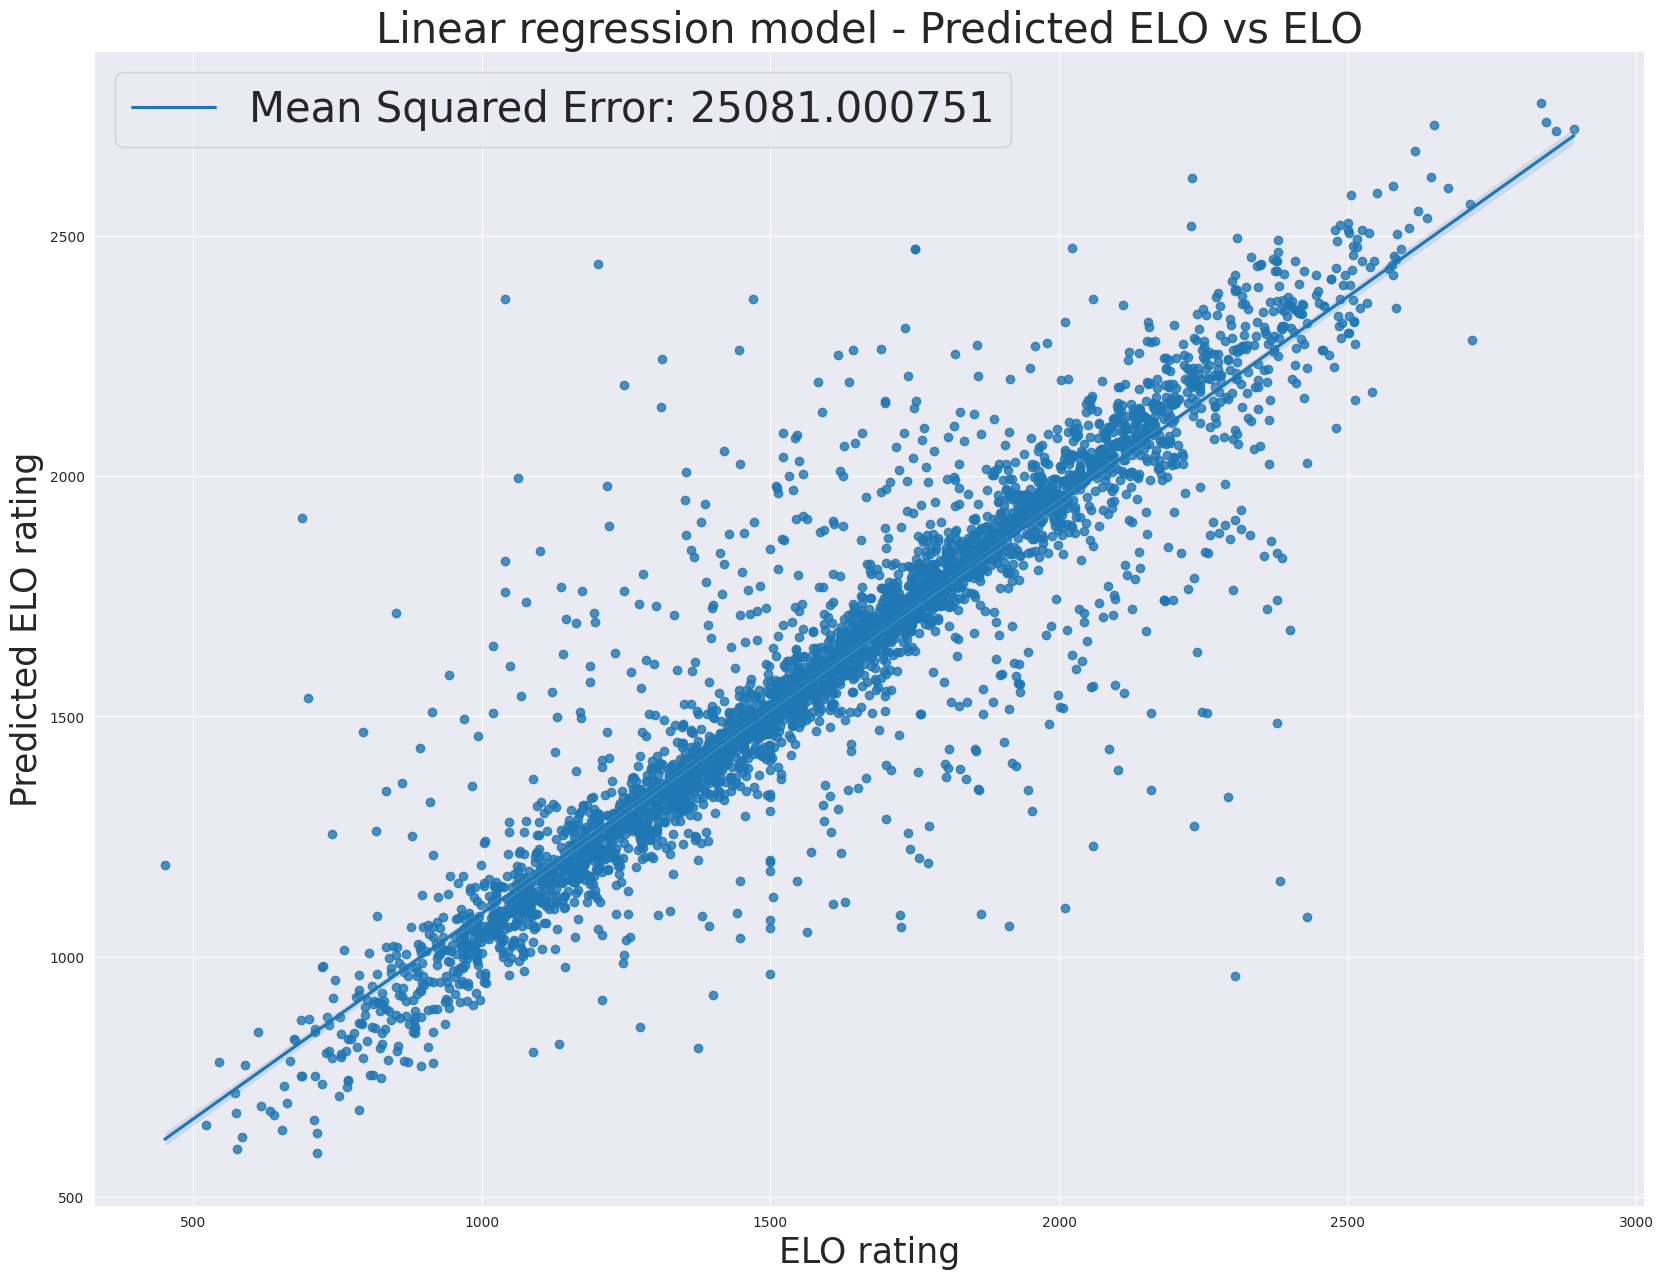

In [51]:
plt.figure(figsize = (20,15))
plt.title('Linear regression model - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = test_elo_transformed, y = y_pred, line_kws = {'label':f'Mean Squared Error: {mse_lin:4f}'})
plt.xlabel('ELO rating', fontsize = 25)
plt.ylabel('Predicted ELO rating', fontsize = 25)
plt.legend(prop={'size': 30})

# Creating the Neural Network

In [52]:
class MyCollator(object):
    '''
    Yields a batch from a list of Items
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''

    def __call__(self, batch):
        white_data = [item[0] for item in batch]
        target = [item[1] for item in batch]
        #print(f"TARGET: {target[7]}")
        white_lens = [i.shape[0] for i in white_data]
        white_data = torch.nn.utils.rnn.pad_sequence(white_data, batch_first=True,padding_value = 0)
        #print("WHite data 2 shape",(white_data).size())
        white_evals_packed = torch.nn.utils.rnn.pack_padded_sequence(white_data,batch_first = True, lengths=white_lens,enforce_sorted=False)
        target = torch.tensor(target,dtype=torch.float64)
        return [white_evals_packed, target]

In [53]:
# defining parameters for the neural net
input_size = 5
hidden_size = 8
no_layers = 2
batch_size = 256

In [54]:
model = MyLSTM(input_size, hidden_size, no_layers)
#model.load_state_dict(torch.load('networks/main_model_epoch_3.pt'))
model.load_state_dict(torch.load('networks/main_model_epoch_82.pt'))
collate = MyCollator()
print(model.parameters)

<bound method Module.parameters of MyLSTM(
  (lstm): LSTM(5, 8, num_layers=2, batch_first=True, bidirectional=True)
  (end): Linear(in_features=32, out_features=1, bias=False)
)>


# Training the model

In [184]:
# defining loss functions
@torch.compile(mode = 'max-autotune')
def custom_loss(outputs, elo):
    criterion = nn.MSELoss()
    l = criterion(outputs,elo)
    var = ((outputs - outputs.mean())**2).mean()
    elo_var = ((elo - elo.mean())**2).mean()
    z = (var-elo_var)**2#(torch.relu((var-elo_var)**2 - 2))
    
    # trying to match minima and maxima
    kurt = ((outputs - outputs.mean())**4).mean()
    elo_kurt = ((elo - elo.mean())**4).mean()
    k = (kurt-elo_kurt)**2  #torch.relu((kurt-elo_kurt)**2  - 10)
    return l+ k/100 + z/100

In [185]:
writer = SummaryWriter('runs/h45l4-2')

In [186]:
learning_rate = .0001

In [59]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [188]:
#criterion = nn.MSELoss()
#criterion = custom_loss
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [189]:
import torch.nn.utils as utils


In [190]:
import matplotlib.ticker as ticker


In [191]:
avg_losses = []
epochs = []
avg_loss = 0.1


test_data_loader = torch.utils.data.DataLoader(test_data_zip, batch_size=batch_size, shuffle=False ,collate_fn=collate)

for epoch in range(1000):
    data_loader = torch.utils.data.DataLoader(train_data_zip, batch_size=batch_size, shuffle=True,collate_fn=collate)
    losses = []
    model.train()
    i = 0
    for white_evals, elo in data_loader:
        white_evals = white_evals.to(device)
        elo = elo.to(device)
        outputs = model(white_evals)
        #print(outputs)buy 
        loss = custom_loss(outputs,elo)
        # optimizing
        optimizer.zero_grad()
        loss.backward()
        #utils.clip_grad_norm_(model.parameters(), 1000)
        #for param in model.parameters():
            #param.grad = torch.clamp(param.grad, min=0.001)
        optimizer.step()
        losses.append(loss.item())
        i+=1


    #evaluating on the test data
    model.eval() 
    tlosses2= []
    for evals, elo in test_data_loader:
        evals = evals.to(device)
        elo = elo.to(device)
        output = model(evals)
        loss = custom_loss(output,elo)
        tlosses2.append(loss.item())
    print("Test loss = ",stats.mean(tlosses2))
    
    change = stats.mean(losses)/avg_loss
    avg_loss = stats.mean(losses)

    # adding histograms to the summary writer
    for name, param in model.named_parameters():
        writer.add_histogram(name, np.array(param.detach().tolist()), epoch)

    # adding loss
    writer.add_scalar('Average loss',stats.mean(losses), epoch)
    avg_losses.append(stats.mean(losses))
    epochs.append(epoch)
    print(f'Epoch {epoch+1+62} step {i+1} - Learning Rate : {learning_rate}- Avg Loss: {stats.mean(losses):3f} - Change in loss: {change}')
    torch.save(model.state_dict(), f'networks/main_model_epoch_{epoch+1+62}.pt')
    formatter = ticker.ScalarFormatter(useMathText=False)
    formatter.set_scientific(False)
    
    # Apply the custom tick formatter to the y-axis
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.scatter(epochs, avg_losses)
    plt.show()
writer.close() 

KeyboardInterrupt: 

## Evaluating the model

In [60]:
model.eval()

MyLSTM(
  (lstm): LSTM(5, 8, num_layers=2, batch_first=True, bidirectional=True)
  (end): Linear(in_features=32, out_features=1, bias=False)
)

In [61]:
model.to(device)


MyLSTM(
  (lstm): LSTM(5, 8, num_layers=2, batch_first=True, bidirectional=True)
  (end): Linear(in_features=32, out_features=1, bias=False)
)

In [62]:
test_data_loader1 = torch.utils.data.DataLoader(test_data_zip, batch_size=1, shuffle=False ,collate_fn=collate)

In [63]:
# getting a list of outputs for the test data
outputs = []
elos = []
for evals, elo in test_data_loader1:
    evals = evals.to(device)
    elo = elo.to(device)
    output = model(evals)
    outputs.append(output.item())
    elos.append(elo.item())
print(f'Average loss : {stats.mean(losses)}')

NameError: name 'losses' is not defined

In [64]:
# preparing data to be inverse transformed
elos = np.array(elos)
elos = np.reshape(elos, (len(elos),1))

outputs = np.array(outputs)
outputs = np.reshape(outputs, (len(outputs),1))


In [65]:
print(outputs.min())

-2.542755313235037


In [66]:
# getting elos from the normalized values
elos = target_pt.inverse_transform(elos)
outputs = target_pt.inverse_transform(outputs)

In [67]:
mse_model = mean_squared_error(elos,outputs)

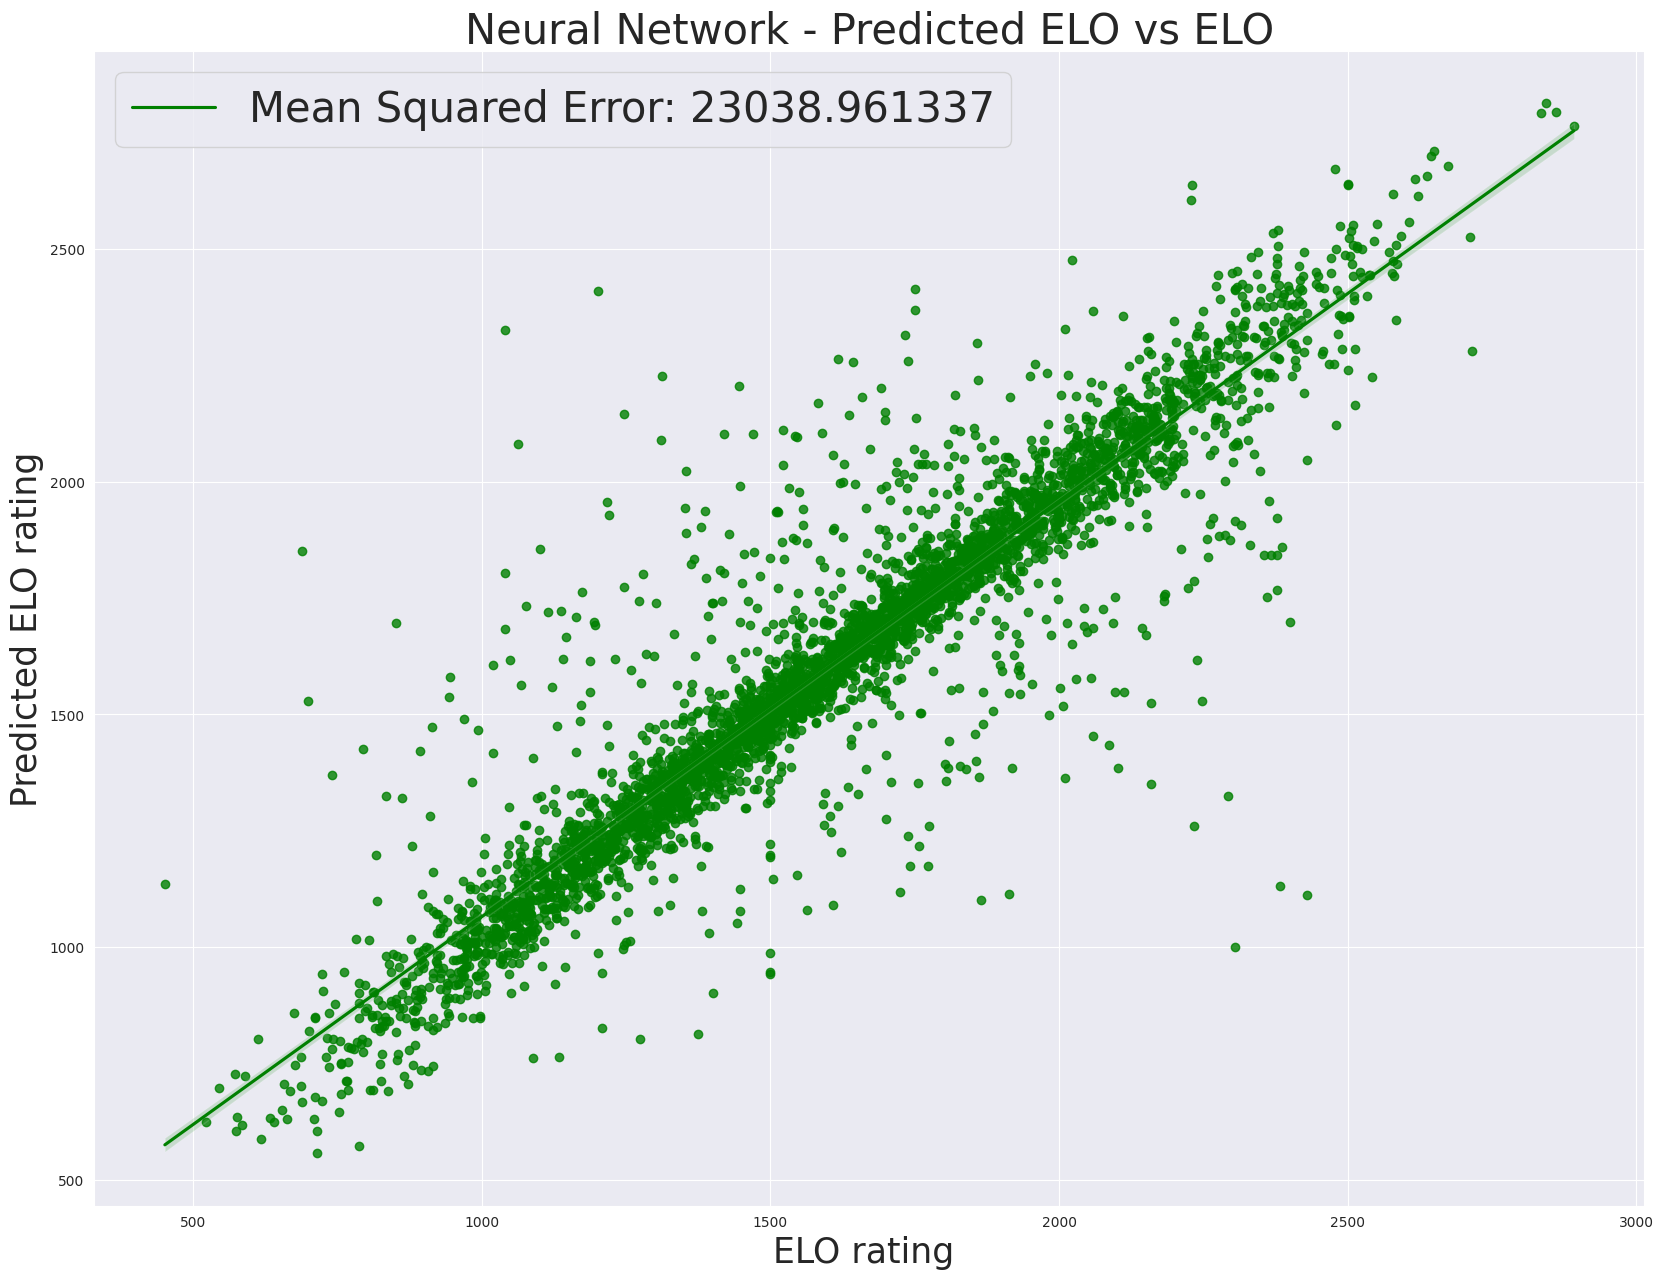

In [68]:
plt.figure(figsize = (20,15))
plt.title('Neural Network - Predicted ELO vs ELO', fontsize = 30)
sns.regplot(x = elos, y = outputs, color ='green', line_kws = {'label':f'Mean Squared Error: {mse_model:4f}'})
plt.xlabel('ELO rating ', fontsize = 25)
plt.ylabel('Predicted ELO rating', fontsize = 25)
plt.legend(prop={'size': 30})
#plt.savefig('images/NN_model_acc1.png')

In [200]:
torch.save(model.state_dict(), 'main_model.pt')

In [ ]:
sns.regplot(elos,outputs)